In [ ]:
# Il faut peut etre run le code suivant pour les import de imageio, engine etc...: 



# %%shell

# # Install pycocotools
# git clone https://github.com/cocodataset/cocoapi.git
# cd cocoapi/PythonAPI
# python setup.py build_ext install
# cd ..
# cd ..

# # Install torchvision useful functions
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../
# cd ..


import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import PIL
import PIL.Image
from PIL import Image
import cv2 #conda install -c conda-forge opencv


import tensorflow
import torchvision
import torch
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


import imageio
from engine import train_one_epoch, evaluate
from utils import collate_fn
from tqdm import tqdm
import utils

## Les fonctions utiles pour définir la pluspart des objets permettants de définir la class TableDataset
Pas très utiles au final car on a déjà run le code et enregistré tous les objets dans des fichiers pickles

In [ ]:


def find_name_from_id(im_id, nb_file, list_dict):
    hashmap_im = {elt['id']: elt for elt in list_dict[nb_file]["images"]}
    return hashmap_im[im_id]["file_name"]

def list_bbox_from_id(im_id, nb_file, list_dict):
    
    list_bbox = [dico['bbox'] for dico in list_dict[nb_file]["annotations"] if dico['image_id'] == im_id]
    return list_bbox

def list_bbox_from_id_to_format_minmax(im_id, nb_file, list_dict):
    
    list_bbox = [convert_COCO_format_to_min_max(dico['bbox']) for dico in list_dict[nb_file]["annotations"] if dico['image_id'] == im_id]
    return list_bbox

def build_list_id(nb_file, list_dict) : 
    hashmap_id = {elt['id']: elt for elt in list_dict[nb_file]["images"]}
    list_id = np.array(list(hashmap_id.keys()))
    return list_id

def draw_bbox(im_id, nb_file, list_dict, path, file_image_name = '' ,bool_display = True):
    # ATTENTION FAUT AOUTER LE PARAMETRE PATH CHEZ TOUS LES APPELS
    
    name = find_name_from_id(im_id, nb_file, list_dict)
    #img_cv = cv2.imread(path+ 'train2018/'+name)
    imgpil = Image.open(path+ file_image_name +name)  
    # anciennement np.asarray
    img = np.array(imgpil) # Transformation de l'image en tableau numpy
    #list_pos_im = find_im_from_id(im_id, nb_file)
    list_bbox = list_bbox_from_id(im_id, nb_file, list_dict)
    for bbox in list_bbox :
        x,y, width, height = np.float32(bbox[0]), np.float32(bbox[1]), np.float32(bbox[2]), np.float32(bbox[3])
        start_point = (x,y)
        end_point = (x+width, y+height)
        color = "blue"
        #plt.figure(figsize=(16,10))
        #im_arr_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.rectangle(img, start_point, end_point, color=(0, 255, 0), thickness=3)   
        im = Image.fromarray(img)
#         plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#         plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#         plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#         plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')
#     plt.imshow(img)
#     plt.show()
    if bool_display :
        display(im)
    return im, name



def build_dict_images(nb_file, threshold,path,  list_dict, file_image_name = '' , bool_display = True):
    list_id = build_list_id(nb_file, list_dict)
    dict_images = {}
    for i,im_id in enumerate(list_id) :
        if i < threshold : 
            im, name = draw_bbox(im_id, nb_file, list_dict, path,file_image_name , bool_display)
            dict_images[name] = im
        else :
            print('Les '+ str(threshold)+' images ont été affichés')
            break
    return dict_images

def create_complete_df(nb_file, list_id, path, list_dict, file=''):
    dict_im = {}
    dict_images = {}
    for i,im_id in enumerate(list_id) :
        name = find_name_from_id(im_id, nb_file, list_dict)
        imgpil = Image.open(path+ file +name)  
        img = np.array(imgpil)
        list_bbox = list_bbox_from_id(im_id, nb_file, list_dict)
        dict_im["im_name"] = name
        dict_im["array"] = img
        dict_im["bboxes"] = list_bbox
        dict_images[im_id] = dict_im
        dict_im = {}
    return pd.DataFrame.from_dict(dict_images,  orient='index')

def create_complete_dictionnary(nb_file, list_id, list_dict, file=''):
    dict_im = {}
    dict_images = {}
    bboxes = []
    img_list = []
    for im_id in tqdm(list_id) :
        name = find_name_from_id(im_id, nb_file, list_dict)
        #imgpil = Image.open(path+ file +name)  
        #img = np.array(imgpil)
        list_bbox = list_bbox_from_id_to_format_minmax(im_id, nb_file, list_dict)
        dict_im["im_name"] = path_table_image + name
        #dict_im["array"] = img
        dict_im["bboxes"] = list_bbox
        dict_images[im_id] = dict_im
        dict_im = {}
        bboxes.append(list_bbox)
        img_list.append(name)
        
    return dict_images, bboxes, img_list

def convert_COCO_format_to_min_max(bbox) : 
    x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
    new_bbox = [x,y,x+w,y+h]
    return new_bbox

    
def convert_list_COCO_to_min_max(list_bbox):
    """
    Faster R CNN ne prends pas le format coco, c'est un format "dégénéré"
    """    
    return [convert_COCO_format_to_min_max(bbox) for bbox in list_bbox]

def convert_matrix_COCO_to_min_max(mat_bbox):
    return np.array([convert_list_COCO_to_min_max(list_bbox) for list_bbox in mat_bbox])
        

### Définition des 2 path, vers le fichier contenant les 6 json d'annotations et vers le fichier contenant les images mêmes

In [ ]:
path_table_annot = "/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/annotations/"
path_table_image = "/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/images/"


In [ ]:
"""
        Code pour générer les dictionnaires d'annotations, et la list de ces dicos,
        et les listes des identifiants des images
"""
        
        
with open(path_table_annot+'tablebank_latex_test.json') as json_data:
    data_dict_latex_test = json.load(json_data)

with open(path_table_annot+'tablebank_latex_train.json') as json_data:
    data_dict_latex_train = json.load(json_data)

with open(path_table_annot+'tablebank_latex_val.json') as json_data:
    data_dict_latex_val = json.load(json_data)

with open(path_table_annot+'tablebank_word_test.json') as json_data:
    data_dict_word_test = json.load(json_data)
    
with open(path_table_annot+'tablebank_word_train.json') as json_data:
    data_dict_word_train = json.load(json_data)

with open(path_table_annot+'tablebank_word_val.json') as json_data:
    data_dict_word_val = json.load(json_data)

list_dict = [
    data_dict_latex_test, 
    data_dict_latex_train,
    data_dict_latex_val,
    data_dict_word_test, 
    data_dict_word_train,
    data_dict_word_val
    ]

list_id_0 = build_list_id(0,list_dict)
list_id_1 = build_list_id(1, list_dict)
list_id_2 = build_list_id(2, list_dict)
list_id_3 = build_list_id(3, list_dict)
list_id_4 = build_list_id(4, list_dict)
list_id_5 = build_list_id(5, list_dict)



"""METHODE AVEC LE DICTIONNAIRE TOP A NE PAS RUN TOUT A ETE ENREGISTREE


    creation des dictionnaires, bboxes, img_list de chaque jeu de données
    a ne pas run, ils sont deja enregistrés en pickle"""
    
dict_images_test, bboxes_test, img_list_test = create_complete_dictionnary(3, list_id_3, list_dict, file='')
dict_images_train, bboxes_train, img_list_train = create_complete_dictionnary(4, list_id_4, list_dict, file='')
dict_images_val, bboxes_val, img_list_val = create_complete_dictionnary(5, list_id_5, list_dict, file='')



cls_names = ["TABLE" for f in range(len(bboxes_train))]
val_cls_names = ["TABLE" for f in range(len(bboxes_val))]
test_cls_names = ["TABLE" for f in range(len(bboxes_test))]

"\n        Code pour générer les dictionnaires d'annotations, et la list de ces dicos,\n        et les listes des identifiants des images\n        On a enregistré tout ces objets dans des pickle\n        \n        \n# with open(path_table_annot+'tablebank_latex_test.json') as json_data:\n#     data_dict_latex_test = json.load(json_data)\n\n# with open(path_table_annot+'tablebank_latex_train.json') as json_data:\n#     data_dict_latex_train = json.load(json_data)\n\n# with open(path_table_annot+'tablebank_latex_val.json') as json_data:\n#     data_dict_latex_val = json.load(json_data)\n\n# with open(path_table_annot+'tablebank_word_test.json') as json_data:\n#     data_dict_word_test = json.load(json_data)\n    \n# with open(path_table_annot+'tablebank_word_train.json') as json_data:\n#     data_dict_word_train = json.load(json_data)\n\n# with open(path_table_annot+'tablebank_word_val.json') as json_data:\n#     data_dict_word_val = json.load(json_data)\n\n# list_dict = [\n#     data_di

In [ ]:


import pickle

def save_obj(obj, name ):
    with open('/home/berrebi/Documents/Code_Python/detection_faster/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('/home/berrebi/Documents/Code_Python/detection_faster/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
                                                  


In [ ]:
"""
Methode pour save les objets 
"""

save_obj(data_dict_latex_test, "data_dict_latex_test_json")
save_obj(data_dict_latex_train, "data_dict_latex_train_json")
save_obj(data_dict_latex_val, "data_dict_latex_val_json")
save_obj(data_dict_word_test, "data_dict_word_test_json")
save_obj(data_dict_word_train, "data_dict_word_train_json")
save_obj(data_dict_word_val, "data_dict_word_val_json")

save_obj(list_dict, "list_dict_json")

save_obj(list_id_0, "list_id_0_json")
save_obj(list_id_1, "list_id_1_json")
save_obj(list_id_2, "list_id_2_json")
save_obj(list_id_3, "list_id_3_json")
save_obj(list_id_4, "list_id_4_json")
save_obj(list_id_5, "list_id_5_json")


# dict_images_test_json = json.dumps("dict_images_test_json")
# dict_images_train_json = json.dumps("dict_images_train_json")
# dict_images_val_json = json.dumps("dict_images_val_json")

save_obj(dict_images_test, "dict_images_test_json")
save_obj(dict_images_train, "dict_images_train_json")
save_obj(bboxes_test, "bboxes_test_json")
save_obj(bboxes_train, "bboxes_train_json")
save_obj(img_list_test, "img_list_test_json")
save_obj(img_list_train, "img_list_train_json")
save_obj(dict_images_val, "dict_images_val_json")
save_obj(bboxes_val, "bboxes_val_json")
save_obj(img_list_val, "img_list_val_json")




'\nMethode pour save les objets \n\n# save_obj(data_dict_latex_test, "data_dict_latex_test_json")\n# save_obj(data_dict_latex_train, "data_dict_latex_train_json")\n# save_obj(data_dict_latex_val, "data_dict_latex_val_json")\n# save_obj(data_dict_word_test, "data_dict_word_test_json")\n# save_obj(data_dict_word_train, "data_dict_word_train_json")\n# save_obj(data_dict_word_val, "data_dict_word_val_json")\n\n# save_obj(list_dict, "list_dict_json")\n\n# save_obj(list_id_0, "list_id_0_json")\n# save_obj(list_id_1, "list_id_1_json")\n# save_obj(list_id_2, "list_id_2_json")\n# save_obj(list_id_3, "list_id_3_json")\n# save_obj(list_id_4, "list_id_4_json")\n# save_obj(list_id_5, "list_id_5_json")\n\n\n# dict_images_val, bboxes_val, img_list_val = create_complete_dictionnary(5, list_id_5, list_dict, file=\'\')\n# dict_images_test_json = json.dumps("dict_images_test_json")\n# dict_images_train_json = json.dumps("dict_images_train_json")\n\n# save_obj(dict_images_test, "dict_images_test_json")\n#

In [ ]:

# """
#     Methode pour load les objets, tres simple
# """
# data_dict_latex_test = load_obj("data_dict_latex_test_json")
# data_dict_latex_train = load_obj("data_dict_latex_train_json")
# data_dict_latex_val = load_obj("data_dict_latex_val_json")
# data_dict_word_test = load_obj("data_dict_word_test_json")
# data_dict_word_train = load_obj("data_dict_word_train_json")
# data_dict_word_val = load_obj("data_dict_word_val_json")


# list_dict = load_obj("list_dict_json")

# list_id_0 = load_obj("list_id_0_json")
# list_id_1 = load_obj( "list_id_1_json")
# list_id_2 = load_obj("list_id_2_json")
# list_id_3 = load_obj("list_id_3_json")
# list_id_4 = load_obj("list_id_4_json")
# list_id_5 =  load_obj("list_id_5_json")

# dict_images_test = load_obj("dict_images_test_json")
# dict_images_train = load_obj("dict_images_train_json")
# dict_images_val = load_obj("dict_images_val_json")

# bboxes_test = load_obj("bboxes_test_json")
# bboxes_train = load_obj("bboxes_train_json")
# bboxes_val = load_obj("bboxes_val_json")

# img_list_test = load_obj("img_list_test_json")
# img_list_train = load_obj("img_list_train_json")
# img_list_val = load_obj("img_list_val_json")

# cls_names = ["TABLE" for f in range(len(bboxes_train))]
# val_cls_names = ["TABLE" for f in range(len(bboxes_val))]
# test_cls_names = ["TABLE" for f in range(len(bboxes_test))]

## Définition de la classe TableDataset

In [ ]:
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, cls_names, bboxes, transforms=None, name="train"):
        self.transforms = transforms
        self.name = name
        self.img_list = img_list
        self.cls_names = cls_names
        self.bboxes = bboxes
# for im_id, dico in tqdm(dict_images.items()): 
#     self.img_list.append(dico['name'])
#     self.bboxes.append(dico['bboxes'])
        self.class_names = {
            "TABLE": 1
        }   

        self.id_class_dict = {self.class_names[name]: name for name in self.class_names}
        self.img_dict = {idx:{"path":'/media/berrebi/Windows/Users/natha/Documents/Statap/TableBank/Detection/images/' + img_path,
                              "class":self.class_names[cls_names[idx]],
                              "bbox": self.bboxes[idx]} 
                        for idx, img_path in enumerate(img_list)}

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        image = imageio.imread(self.img_dict[image_id]['path']).astype(np.uint8)[...,None]
        image = np.squeeze(image, axis = 3)
        return image


    def __getitem__(self, image_id):   
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        # Retrieve the image and appropriate info
        """
        Create the image, label and bbox variables using the implemented img_dict dictionary.
        """
#         np_img = np.squeeze(self.load_image(image_id), axis=(3) )
#         np_img = np.squeeze(np_img, axis=(0) )# axis=2 is channel dimension 
        #image_ = Image.fromarray((self.load_image(image_id) * 255).astype(np.uint8))
        image = Image.fromarray(self.load_image(image_id)).convert("RGB")
        
#         x = torch.FloatTensor(3, 256, 256).uniform_(0, 1)  # [0, 1] float matrix
#         image = ToPILImage()(x)  # image corresponding to x
        label = self.img_dict[image_id]["class"]
        bbox = self.img_dict[image_id]["bbox"]

        # Convert everything to tensor
        image_id = torch.tensor([image_id])
        """
        on remplace ces deux lignes par la suivante et son commentaire
        les deux lignes ne fonctionnent pas et entrainent l'erreur dans model(imgs, targets) avec index 0 ..
        boxes = torch.as_tensor([bbox], dtype=torch.float32)
        boxes = np.squeeze(boxes, axis = 0)
        """
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        #boxes = np.squeeze(boxes, axis = 0)
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #labels = torch.as_tensor([label], dtype=torch.int64)  #ne fonctionne pas car si ya plusieur objets il associera toujours qu'un seul label -> index 0 with dim 1 out of bound

        # Compute the area of the bounding box
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Use the COCO template for targets to be able to evaluate the model with COCO API
        target = {"boxes": boxes,
                  "labels": labels,
                  "image_id": image_id,
                  #"area": area,
                  "iscrowd": torch.as_tensor([0], dtype=torch.int64)}

        # Important line! don't forget to add this
        if self.transforms:
            image, target = self.transforms(image, target)
   # return the image, the boxlist and the idx in your dataset
        
        return image, target

    def __len__(self):
        return len(self.img_list)

In [ ]:
import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
train2 = TableDataset(img_list_train, cls_names, bboxes_train, get_transform(train=True), name="train")
val2 = TableDataset(img_list_val, val_cls_names, bboxes_val, get_transform(train=False), name="validation")
test2 = TableDataset(img_list_test, test_cls_names, bboxes_test, get_transform(train=False), name="test")

### Exemple de visualistion de bounding box
L'exemple est d'ailleurs mal labélisé 

## Création des dataloader
Idealement : AUGMENTER LE NB DE WORKER SI POSSIBLE

In [ ]:
# Data loaders
torch.manual_seed(1)

num_works = 8

data_loader = torch.utils.data.DataLoader(
    train2, batch_size=4, shuffle=True, num_workers=num_works ,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    val2, batch_size=2, shuffle=True, num_workers=num_works ,
    collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test2, batch_size=2, shuffle=True, num_workers=num_works ,
    collate_fn=collate_fn)

In [ ]:
def compute_means(dataset):
    return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

def compute_stds(dataset):
    return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

image_mean = compute_means(train2)
image_std = compute_stds(train2)


print("Means: {}".format(image_mean))
print("Stds: {}".format(image_std))


## Definition du modèle


Enregistrer le modèle



In [ ]:
FILE_model_dict = "model_state_dict_sog_optimizer1.pth"
FILE_model = "model_sog_optimizer1.pth"

In [ ]:
#Si besoin de load un model
# model.load_state_dict(torch.load(FILE_model_dict))

<All keys matched successfully>

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             image_mean=image_mean,
                                                             image_std=image_std)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2

# get number of input channels for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {:.4e}".format(params))


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]


optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate
# Change the scheduler type if you wish
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.5)


In [ ]:
import math
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for i, values in tqdm(enumerate(metric_logger.log_every(data_loader, print_freq, header))):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Feed the training samples to the model and compute the losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        print("Loss is {}, stopping training".format(loss_value))
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        # Pytorch function to initialize optimizer
        optimizer.zero_grad()
        # Compute gradients or the backpropagation
        losses.backward()
        # Update current gradient
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # Record losses to plot learning curves
        if i == 0: 
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history



def validate_one_epoch(model, data_loader, device=device, print_freq=100):
    # model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Validation: "
    for i, values in tqdm(enumerate(metric_logger.log_every(data_loader, print_freq, header))):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

        # Record losses to plot learning curves
        if i == 0: 
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history


In [ ]:

num_epochs = 100

for epoch in tqdm(range(num_epochs)):

    # Train for one epoch, printing every 10 iterations
    train_his_ = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)

    # Compute losses over the validation set
    val_his_ = validate_one_epoch(model, val_data_loader, device, print_freq=100)

    # Update the learning rate
    lr_scheduler.step()

    # Store loss values to plot learning curves afterwork.
    if epoch == 0: 
        train_history = {k: [v] for k, v in train_his_.items()}
        val_history = {k: [v] for k, v in val_his_.items()}
    else: 
        for k, v in train_his_.items():train_history[k] += [v]
        for k, v in val_his_.items():val_history[k] += [v]

    # On peut save le modèle dans la boucle en ajoutant un critère : si la validation decroit
    # torch.save(model, save_path)

    torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'utils' is not defined

In [ ]:
for k in train_history:
    """ VISUALISER LES RESULTATS DU TRAIN """
    plt.plot(np.arange(len(train_history[k]), dtype=int), train_history[k]/np.max(train_history[k]), label='Train')
    plt.plot(np.arange(len(val_history[k]), dtype=int), val_history[k]/np.max(val_history[k]), label='Validation')
    plt.title(k)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Voila le code utilisé pour notre modèle car nous n'utilisions N_ITERS qui nous permettait de specifier le nombre de batch utilisés pour l'entrainement (impossible de faire une epoch entière)

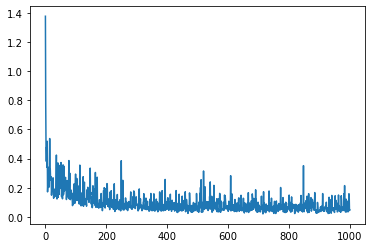


batch loss: 0.047418780624866486, average loss: 0.09724807748384774.: 100%|██████████| 1000/1000 [6:44:11<00:00, 24.25s/it]
100%|██████████| 1000/1000 [6:44:11<00:00, 24.25s/it]


In [ ]:
# N_ITERS = 1000


# progress_bar = tqdm(range(N_ITERS))
# tr_it = iter(data_loader)
# loss_log = []
# iterations = []

# j=0 
# for i in tqdm(progress_bar):
#     try :
#         if True :
#             print("on est dans le premier try")
            
#         try:
#             print("on est dans le 2e try")
            
#             data = next(tr_it)
#         except StopIteration:
#             print("on est dans l'expect du 2e try")
            
#             tr_it = iter(data_loader)
#             data = next(tr_it)
#         model.train()
#         torch.set_grad_enabled(True)

#         losses = forward_train(model, data, device)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         loss_log.append(losses.item())
#         iterations.append(i)
#         progress_bar.set_description(f'batch loss: {losses.item()}, average loss: {np.mean(loss_log)}.')
#         save_obj(loss_log, "loss_log_1000_premieres_iterations" )

#         clear_output(True)
#         plt.plot(iterations, loss_log)
#         plt.show()
#     except :
#         print("on est dans le 2e excpect \n ")
            
#         print("Et on a un pb en le step " , i)
        
        
        


In [ ]:
""" A run si on veut save la loss, penser à changer le nom du fichier"""
#save_obj(loss_log, "loss_log_1000_premieres_iterations" )


' A run si on veut save la loss, penser à changer le nom du fichier'

In [ ]:
#model.state_dict()

In [ ]:
""" A run pour save le nouveau modèle, penser à changer les nom des fichiers FILEs"""

torch.save(model.state_dict(), FILE_model_dict)
torch.save(model, FILE_model)

#### Plusieurs Exemples de prédiction sur un modèle avec 1000 batchs d'entrainements et sans NMS

In [ ]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
tr_it_test = iter(test_data_loader)


In [ ]:
images, targets = next(tr_it_test)
images_test = list(img.to(device) for img in images)
targets_test = [{k: v.to(device) for k, v in t.items()} for t in targets]


In [ ]:
images_test[0].shape

torch.Size([3, 792, 612])

In [ ]:
targets_test[0]

{'boxes': tensor([[ 72., 660., 540., 711.]]),
 'labels': tensor([1]),
 'image_id': tensor([605]),
 'iscrowd': tensor([0])}

In [ ]:
model_time = time.time()
outputs = model(images_test)

outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
model_time = time.time() - model_time

res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
evaluator_time = time.time()

In [ ]:
outputs

[{'boxes': tensor([[ 70.5211, 655.1098, 524.6807, 720.8835],
          [ 74.5668, 554.1202, 538.1688, 630.8824],
          [ 74.3787, 187.7635, 540.0999, 281.4228],
          [ 77.0592, 182.1785, 523.5980, 436.0115],
          [611.9312,   2.2970, 612.0000,   9.6031],
          [ 77.2780, 323.8257, 534.9642, 437.0738],
          [ 84.6515, 385.5928, 536.8005, 432.5426],
          [ 69.3329, 564.6813, 529.9818, 719.3948],
          [ 71.7688, 158.2491, 539.7228, 674.6310],
          [ 87.6757, 333.0520, 535.3192, 383.1596]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9391, 0.8615, 0.8587, 0.7306, 0.3517, 0.2446, 0.2083, 0.0973, 0.0820,
          0.0518], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 80.8483, 214.5633, 492.0141, 273.4279],
          [595.9090,   0.0000, 596.0000,   6.6236],
          [155.9388, 215.3877, 371.9624, 270.8336]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([0.9932, 0.3

In [ ]:
res

{605: {'boxes': tensor([[ 70.5211, 655.1098, 524.6807, 720.8835],
          [ 74.5668, 554.1202, 538.1688, 630.8824],
          [ 74.3787, 187.7635, 540.0999, 281.4228],
          [ 77.0592, 182.1785, 523.5980, 436.0115],
          [611.9312,   2.2970, 612.0000,   9.6031],
          [ 77.2780, 323.8257, 534.9642, 437.0738],
          [ 84.6515, 385.5928, 536.8005, 432.5426],
          [ 69.3329, 564.6813, 529.9818, 719.3948],
          [ 71.7688, 158.2491, 539.7228, 674.6310],
          [ 87.6757, 333.0520, 535.3192, 383.1596]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9391, 0.8615, 0.8587, 0.7306, 0.3517, 0.2446, 0.2083, 0.0973, 0.0820,
          0.0518], grad_fn=<IndexBackward>)},
 1443: {'boxes': tensor([[ 80.8483, 214.5633, 492.0141, 273.4279],
          [595.9090,   0.0000, 596.0000,   6.6236],
          [155.9388, 215.3877, 371.9624, 270.8336]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([

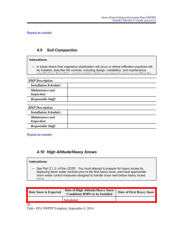

In [ ]:
""" ICI ENCORE LA DONNEE EST MAL LABELISEE """

img_id = 605
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

for i in range(len(info['boxes'])):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = info['boxes'][i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


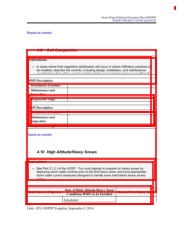

In [ ]:
img_id = 605
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

bbox = res[img_id]['boxes']
for i in range(len(bbox)):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = bbox[i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


##### Exemple 2

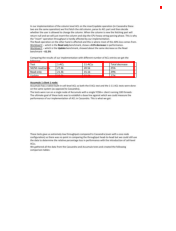

In [ ]:
img_id = 1443
img, info = test2[img_id]
# Get bounding box coordinates
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

bbox = res[img_id]['boxes']
for i in range(len(bbox)):
# ******************************* COCO CASE *********************************
#     x,y,width,height = info['boxes'][i]
#     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
#     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
#     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

    x_min ,y_min , x_max, y_max = bbox[i]
    plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
    plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
    plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


plt.axis('off')
plt.show()


##### Exemple 3

In [ ]:
imgs, targs = next(tr_it_test)
imgs_test = list(img.to(device) for img in imgs)
targs_test = [{k: v.to(device) for k, v in t.items()} for t in targs]


In [ ]:
model_time2 = time.time()
outputs2 = model(imgs_test)

outputs2 = [{k: v.to(device) for k, v in t.items()} for t in outputs2]
model_time2 = time.time() - model_time2

res2 = {target["image_id"].item(): output for target, output in zip(targs, outputs2)}
evaluator_time2 = time.time()

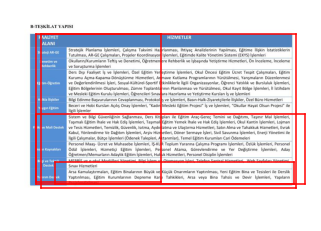

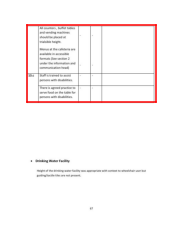

In [ ]:

list_index = list(res2.keys())

for img_id in list_index:
    img, info = test2[img_id]
    # Get bounding box coordinates
    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

    bbox = res2[img_id]['boxes']
    for i in range(len(bbox)):
    # ******************************* COCO CASE *********************************
    #     x,y,width,height = info['boxes'][i]
    #     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
    #     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
    #     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
    #     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

        x_min ,y_min , x_max, y_max = bbox[i]
        plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
        plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
        plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
        plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


    plt.axis('off')
    plt.show()


##### Exemple 4

  0%|          | 0/5 [00:00<?, ?it/s]

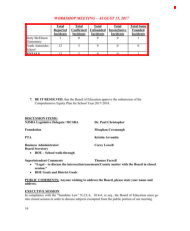

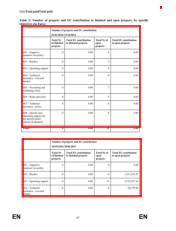


 20%|██        | 1/5 [00:20<01:21, 20.28s/it]

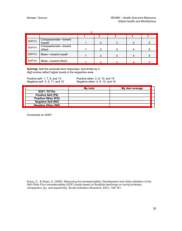

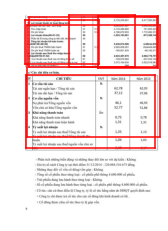


 40%|████      | 2/5 [03:57<03:58, 79.49s/it]

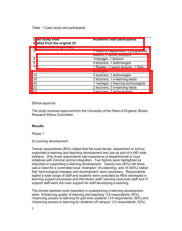

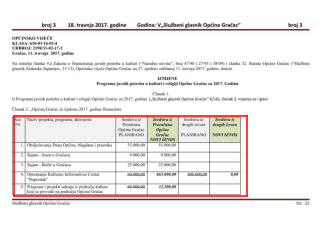


 60%|██████    | 3/5 [06:31<03:23, 101.60s/it]

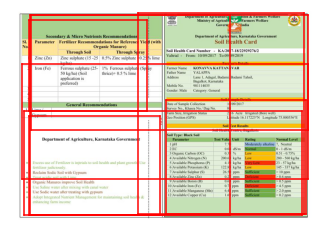

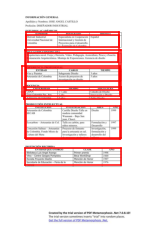


 80%|████████  | 4/5 [09:35<02:06, 126.48s/it]

In [ ]:

progress_bar_test = tqdm(range(5))

for i in tqdm(progress_bar_test) : 

    imgs, targs = next(tr_it_test)
    imgs_test = list(img.to(device) for img in imgs)
    targs_test = [{k: v.to(device) for k, v in t.items()} for t in targs]

    model_time2 = time.time()
    outputs2 = model(imgs_test)

    outputs2 = [{k: v.to(device) for k, v in t.items()} for t in outputs2]
    model_time2 = time.time() - model_time2

    res2 = {target["image_id"].item(): output for target, output in zip(targs, outputs2)}
    evaluator_time2 = time.time()

    list_index = list(res2.keys())

    for img_id in list_index:
        img, info = test2[img_id]
        # Get bounding box coordinates
        plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")

        bbox = res2[img_id]['boxes']
        for i in range(len(bbox)):
        # ******************************* COCO CASE *********************************
        #     x,y,width,height = info['boxes'][i]
        #     plt.plot([x, x+width], [y,y], color = 'red', linestyle = 'solid')
        #     plt.plot([x, x], [y,y+height], color = 'red', linestyle = 'solid')
        #     plt.plot([x + width, x + width], [y+height, y], color = 'red', linestyle = 'solid')
        #     plt.plot([x, x + width], [y+height, y+height], color = 'red', linestyle = 'solid')

            x_min ,y_min , x_max, y_max = bbox[i]
            plt.plot([x_min, x_max], [y_min,y_min], color = 'red', linestyle = 'solid')
            plt.plot([x_min, x_min], [y_min,y_max], color = 'red', linestyle = 'solid')
            plt.plot([x_max, x_max], [y_max, y_min], color = 'red', linestyle = 'solid')
            plt.plot([x_min, x_max ], [y_max, y_max], color = 'red', linestyle = 'solid')


        plt.axis('off')
        plt.show()


### Utilisation du NMS (non max suppression) 
Ce serait bien de faire varier le seuil threshold 

In [ ]:
def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


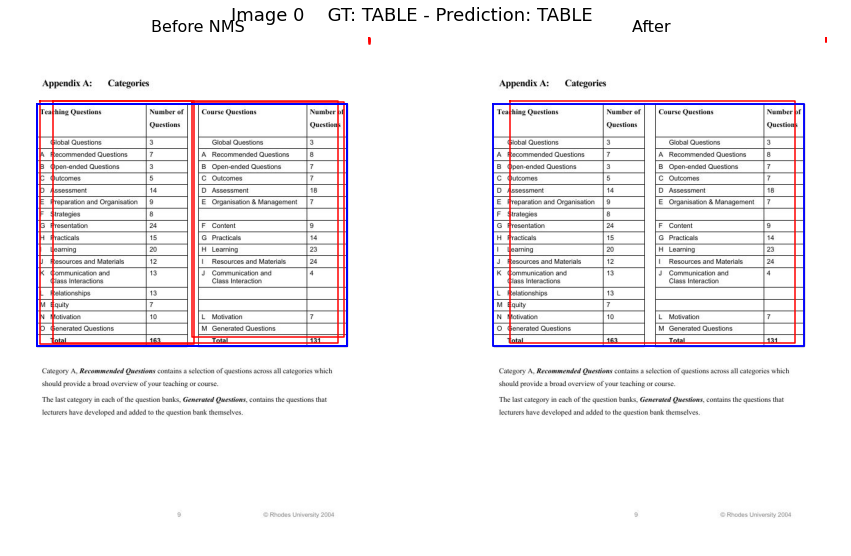

In [ ]:
# VISUALIZATION

# CHOOSE A THRESHOLD FOR NMS
threshold = 0.01 


# Select image in test set
img, target = test2[0]
# Put model in evaluation mode
model.eval()
# Perform prediction
with torch.no_grad(): prediction = model([img.to(device)])

# Retrieve ground-truth and predicted label
gt_label = test2.id_class_dict[target['labels'].item()]
pred_label = test2.id_class_dict[prediction[0]["labels"][0].item()]

# Retrieve predicted bounding boxes and scores 
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot predicted bouding boxes before and after NMS
plt.figure(figsize=(15, 10))
plt.suptitle("Image {}    GT: {} - Prediction: {}".format(0, gt_label, pred_label), y=0.9, fontsize=18)
plt.subplot(121)
plt.title("Before NMS", fontsize=16)
plt.axis('off')


for i in range(len(boxes)):        

    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][0]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

    box_label = test2.id_class_dict[prediction[0]["labels"][i].item()]
    if "NO" in box_label: c = "g-"
    else: c = "r-"
    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)


kept_boxes = non_max_suppression(boxes, scores, threshold)
plt.subplot(122)
plt.title('After ', fontsize=16)
plt.axis('off')
for i in kept_boxes:        
    
    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][0]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

    box_label = test2.id_class_dict[prediction[0]["labels"][i].item()]
    if "NO" in box_label: c = "g-"
    else: c = "r-"
    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)
plt.show()

#### 30 exemples d'utilisations de NMS mais sur certains il y a des erreurs (leur id est dans la liste list_pb) 

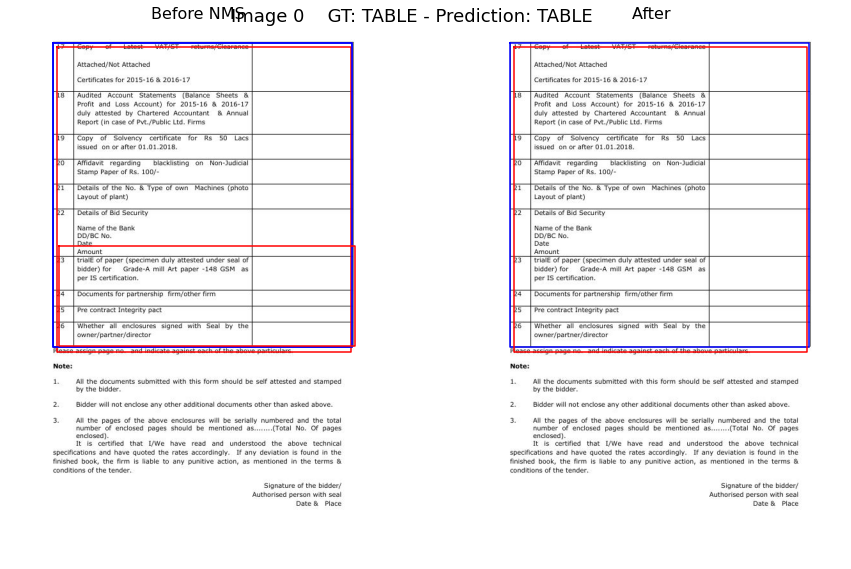

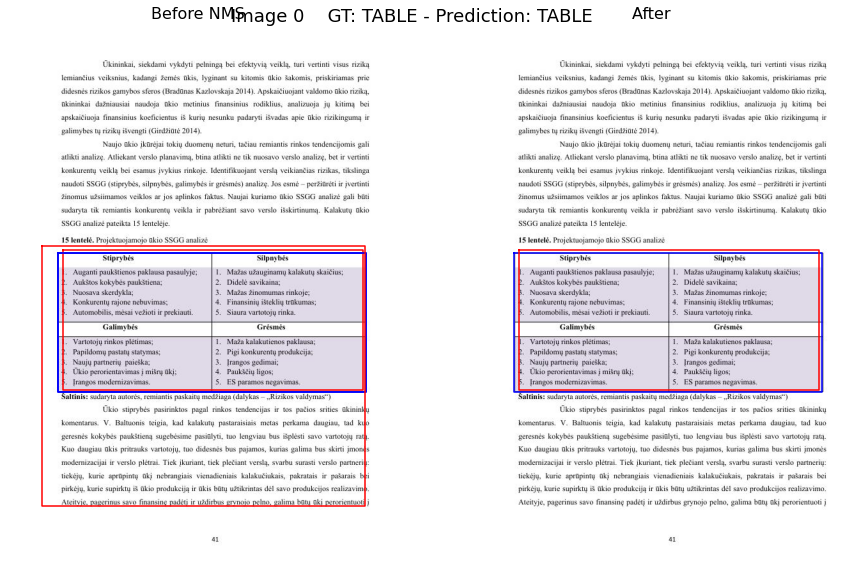

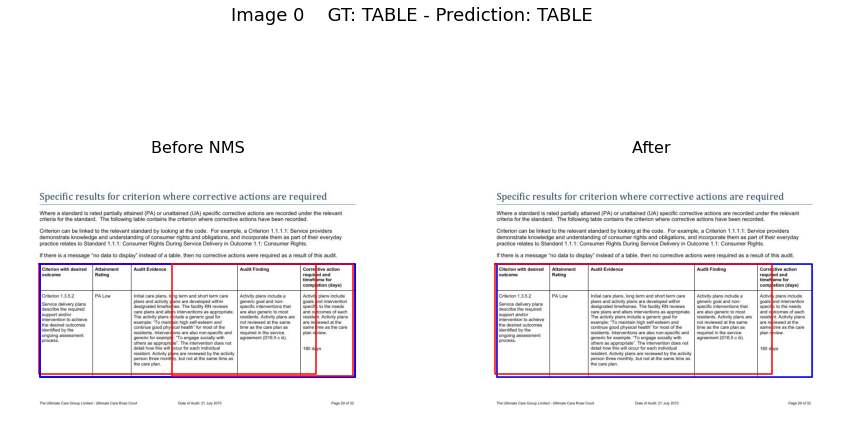

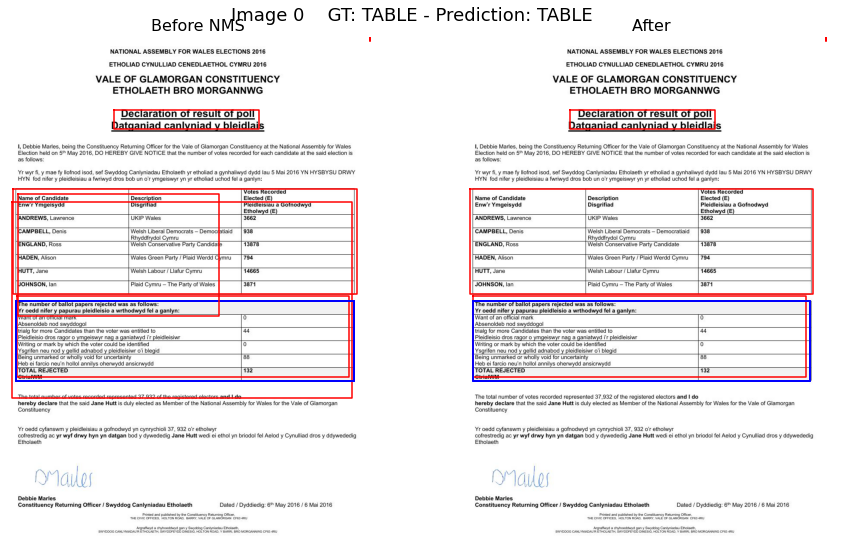

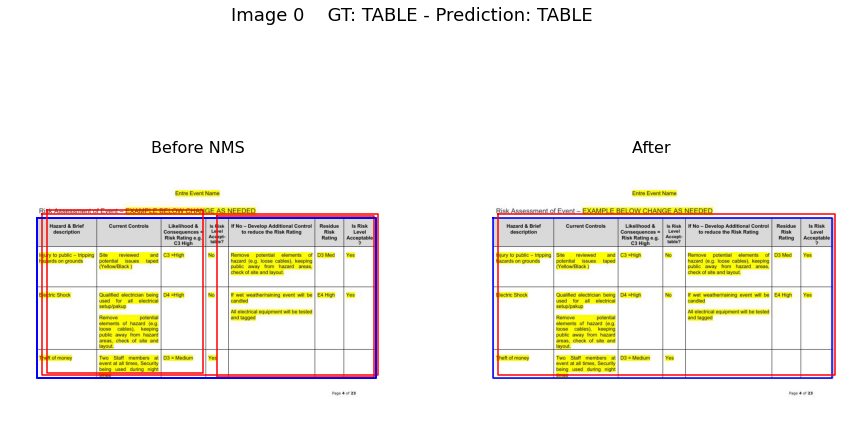

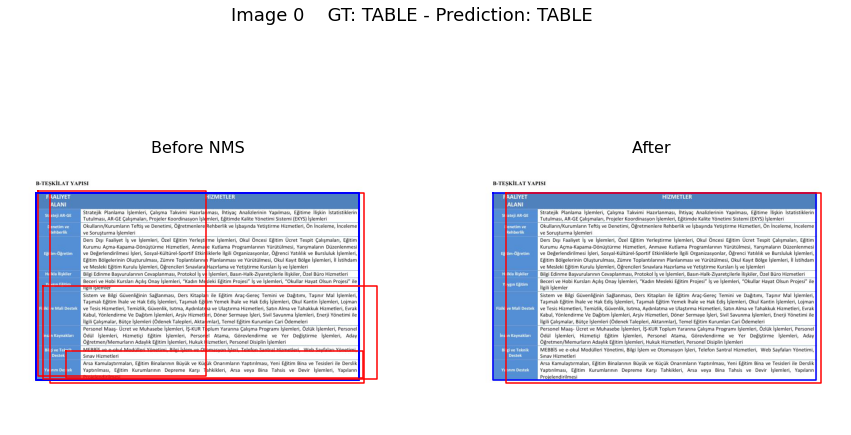

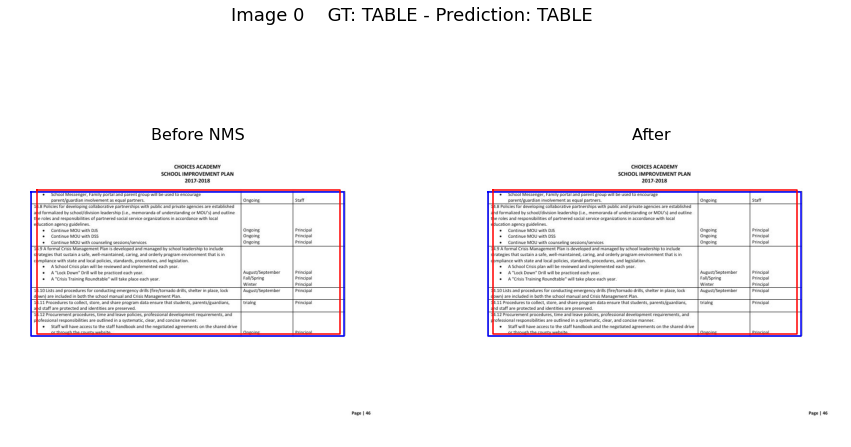

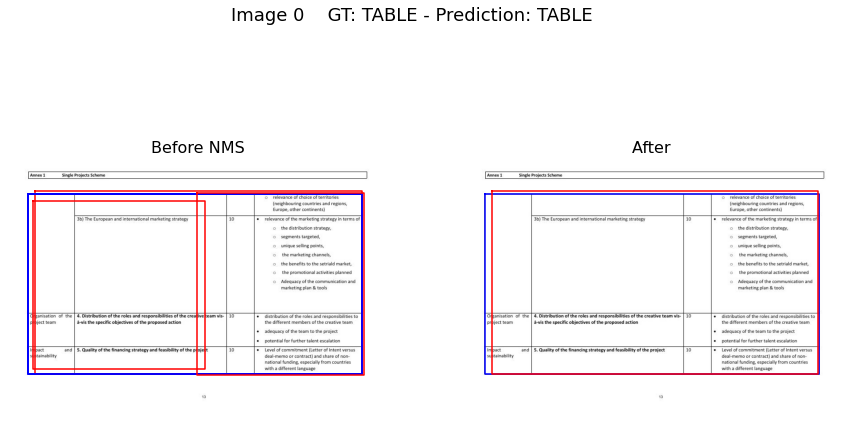

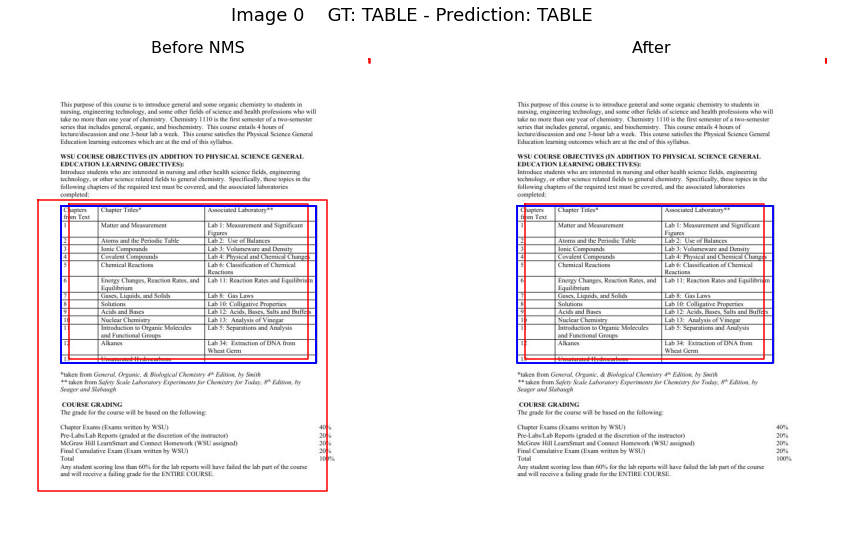

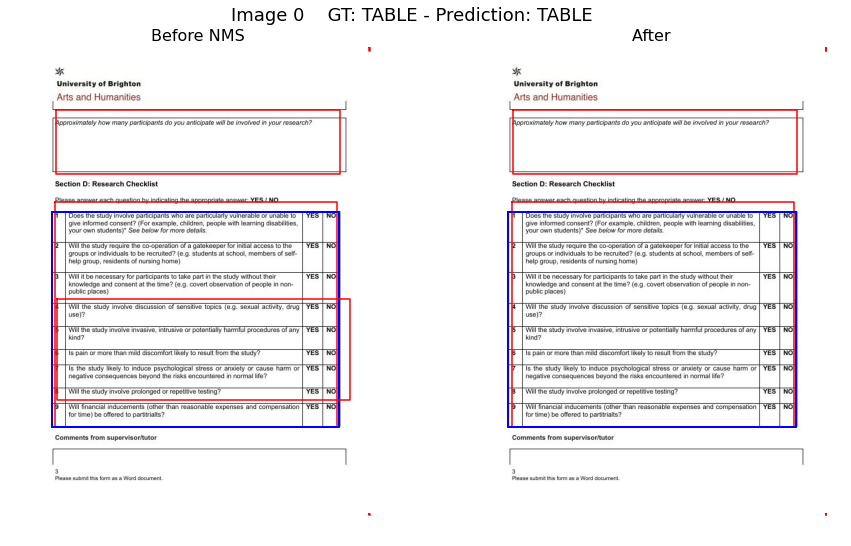

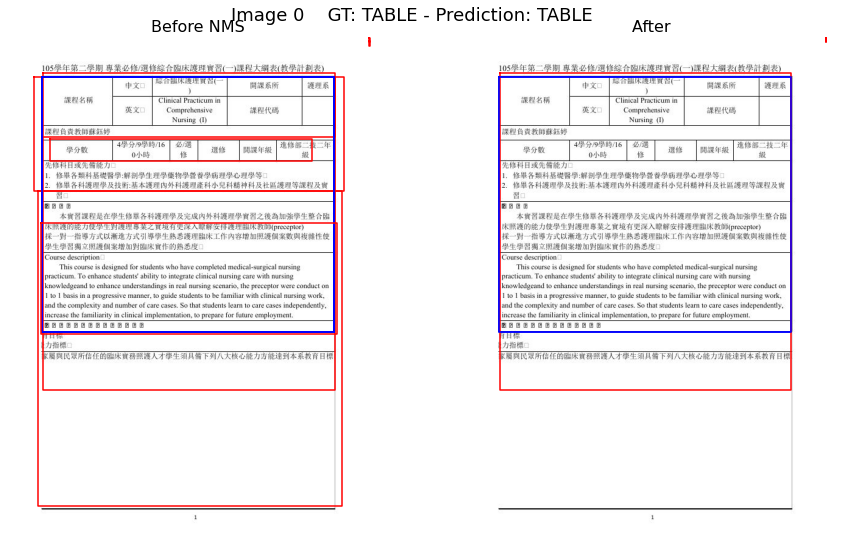

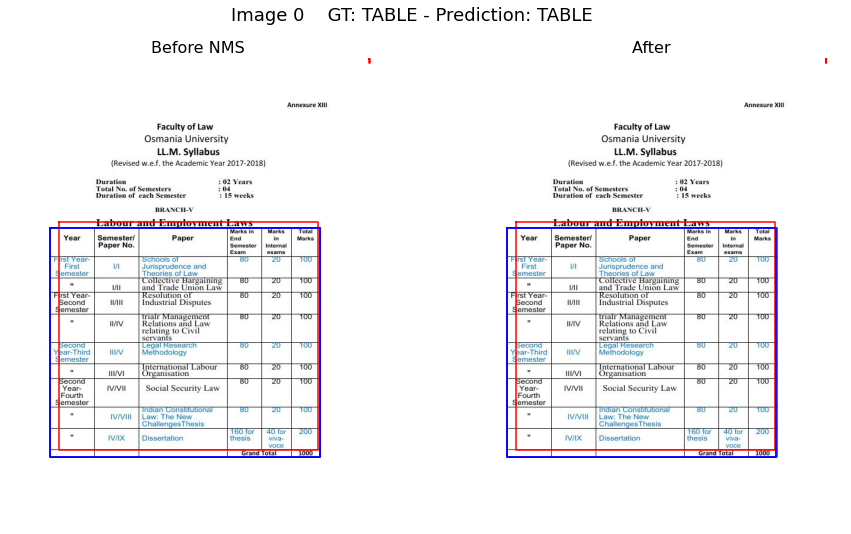

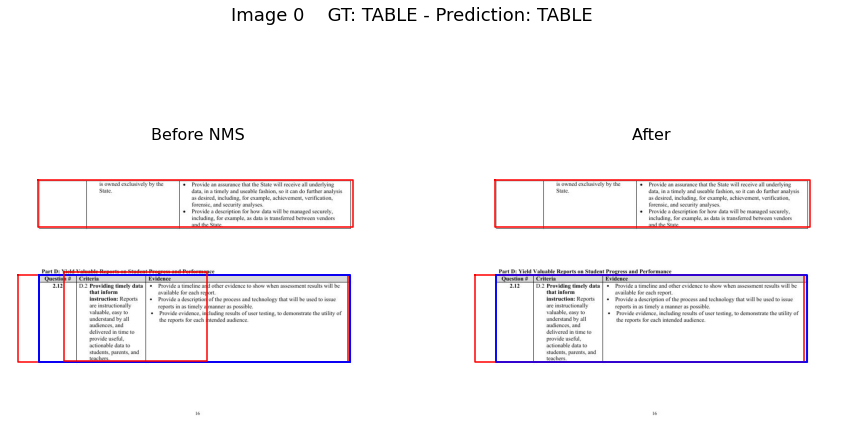

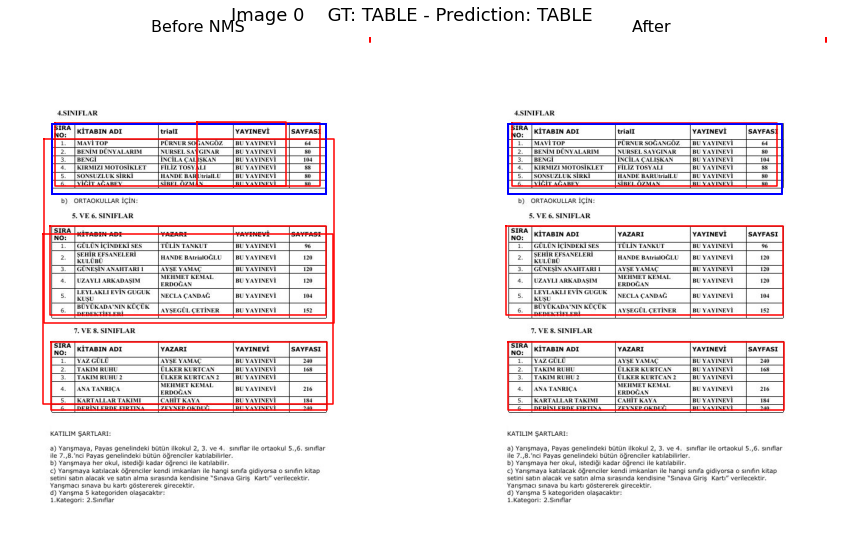

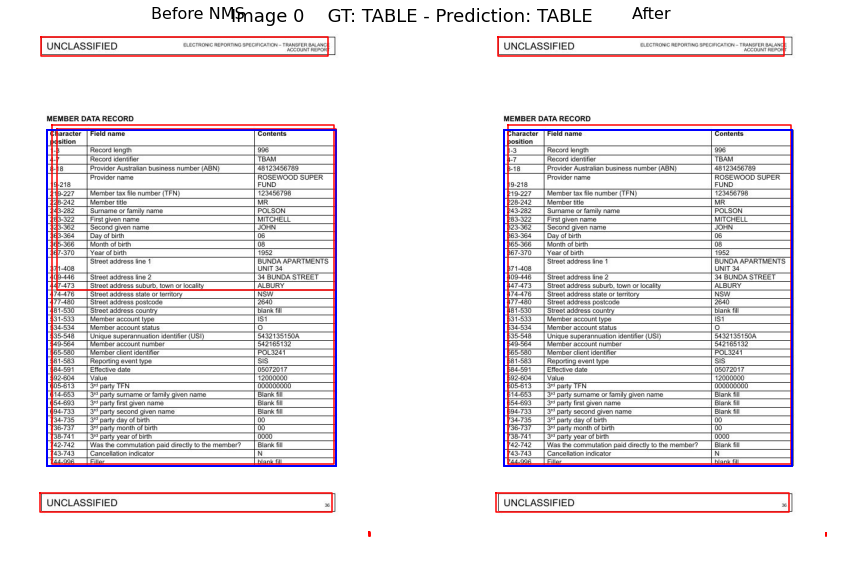

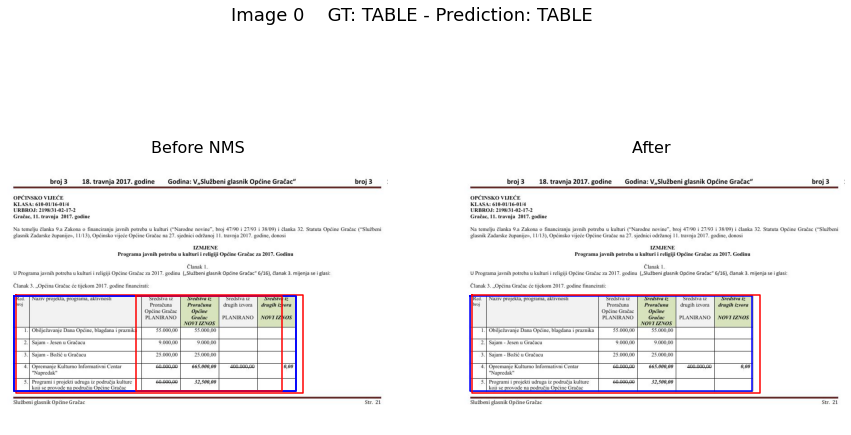

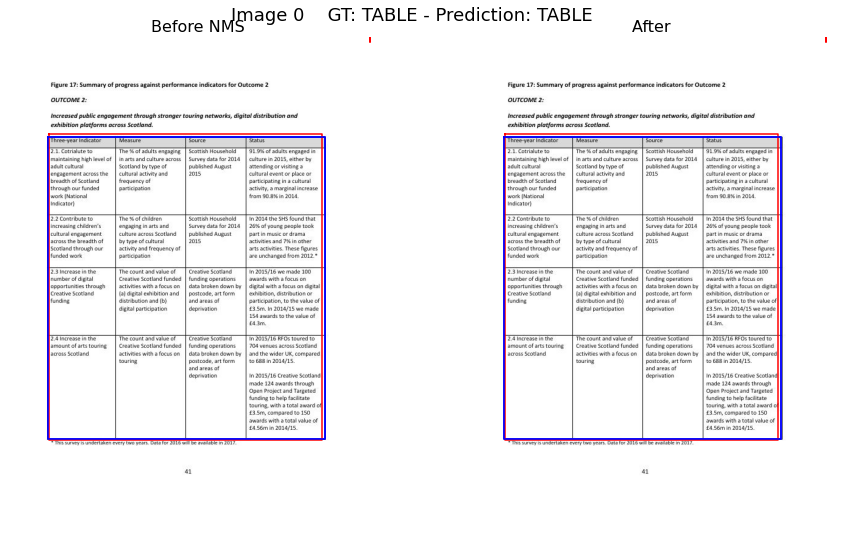

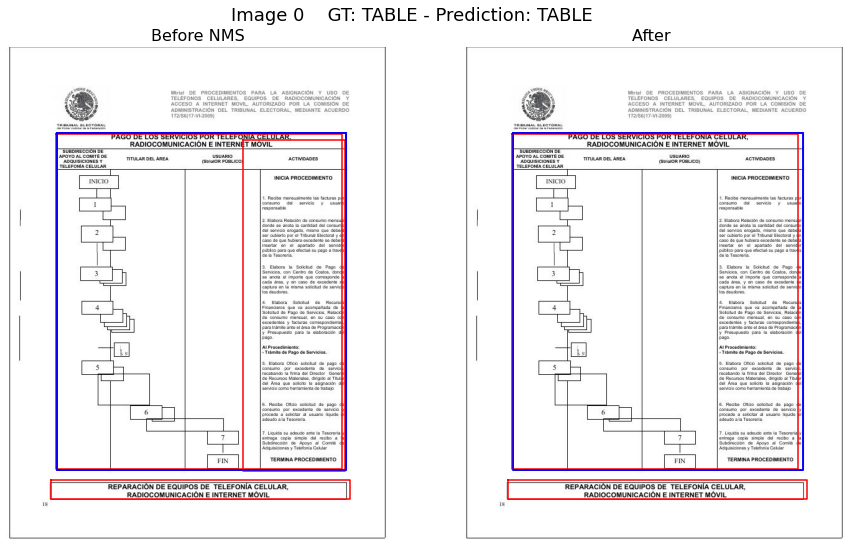

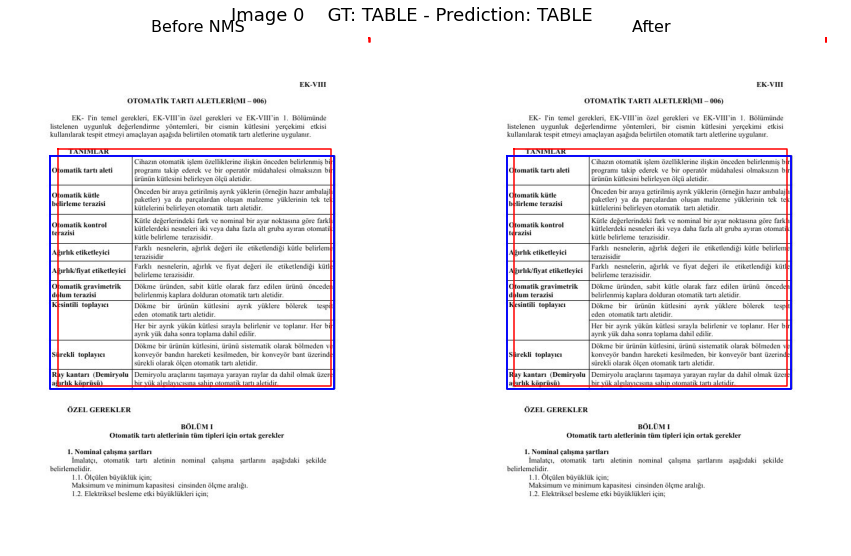

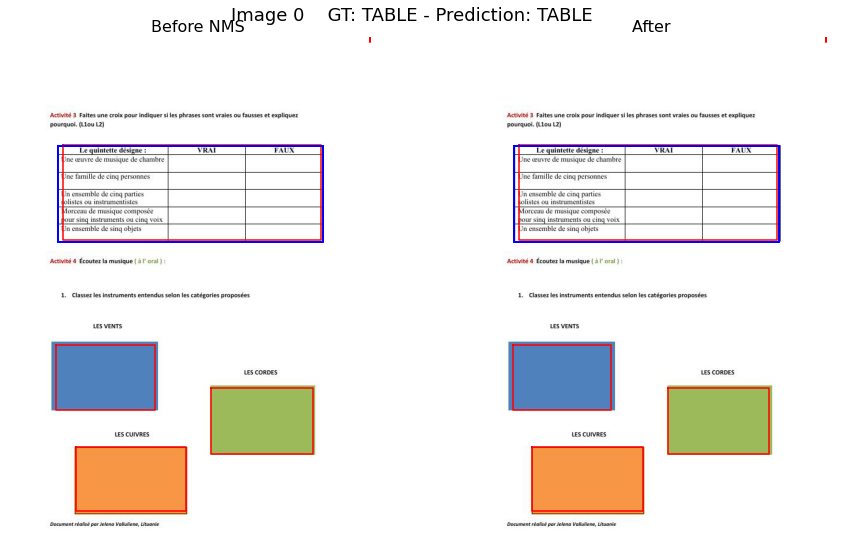

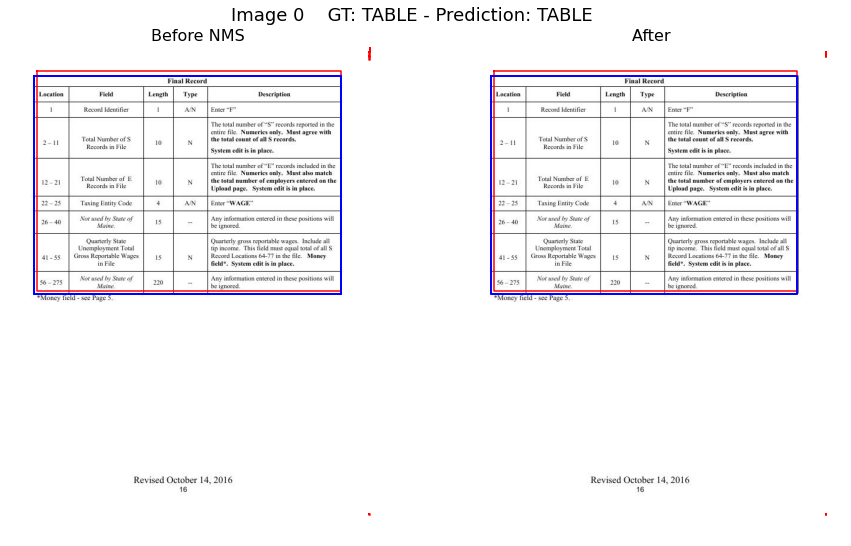

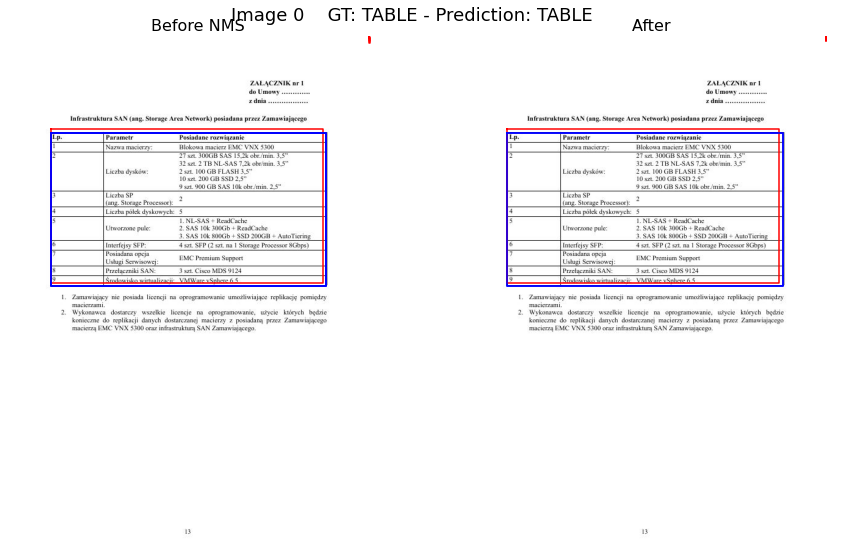

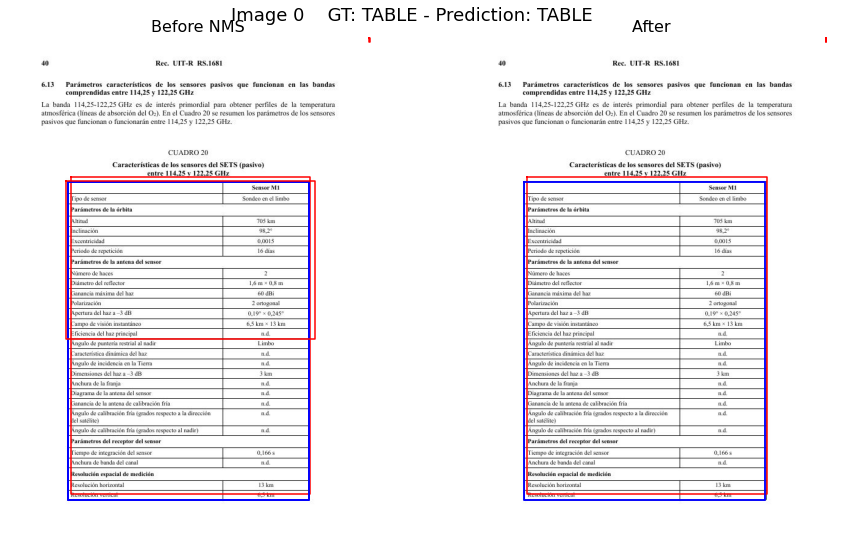

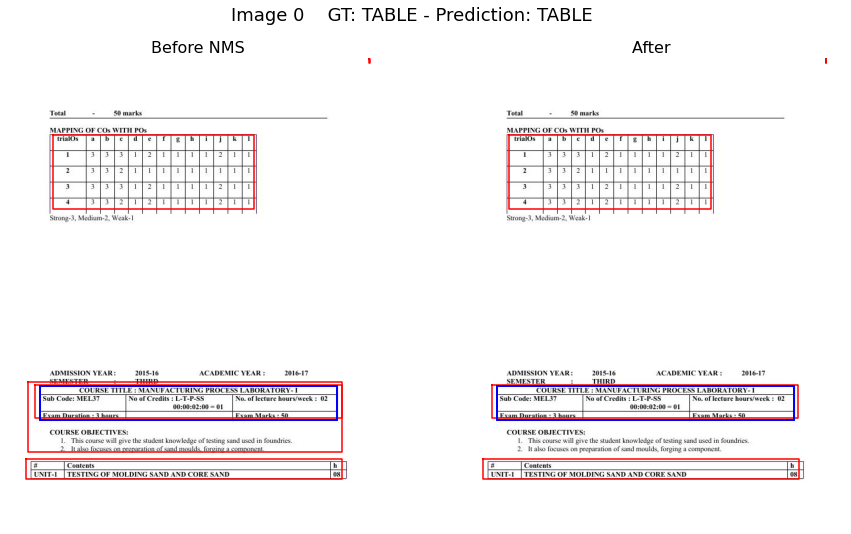

In [ ]:
k=31
list_pb = []
# VISUALIZATION
for ji in range(k,k+30):
    try :
        # CHOOSE A THRESHOLD FOR NMS
        threshold = 0.01 


        # Select image in test set
        img, target = test2[ji]
        # Put model in evaluation mode
        model.eval()
        # Perform prediction
        with torch.no_grad(): prediction = model([img.to(device)])

        # Retrieve ground-truth and predicted label
        gt_label = test2.id_class_dict[target['labels'].item()]
        pred_label = test2.id_class_dict[prediction[0]["labels"][0].item()]

        # Retrieve predicted bounding boxes and scores 
        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()

        # Plot predicted bouding boxes before and after NMS
        plt.figure(figsize=(15, 10))
        plt.suptitle("Image {}    GT: {} - Prediction: {}".format(0, gt_label, pred_label), y=0.9, fontsize=18)
        plt.subplot(121)
        plt.title("Before NMS", fontsize=16)
        plt.axis('off')


        for i in range(len(boxes)):        

            plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
            x1,y1,x2,y2 = target["boxes"][0]
            plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

            box_label = test2.id_class_dict[prediction[0]["labels"][i].item()]
            if "NO" in box_label: c = "g-"
            else: c = "r-"
            x1,y1,x2,y2 = prediction[0]['boxes'][i]
            plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)


        kept_boxes = non_max_suppression(boxes, scores, threshold)
        plt.subplot(122)
        plt.title('After ', fontsize=16)
        plt.axis('off')
        for i in kept_boxes:        

            plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
            x1,y1,x2,y2 = target["boxes"][0]
            plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

            box_label = test2.id_class_dict[prediction[0]["labels"][i].item()]
            if "NO" in box_label: c = "g-"
            else: c = "r-"
            x1,y1,x2,y2 = prediction[0]['boxes'][i]
            plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)
        plt.show()
        k+=1
    except :
        list_pb.append(k)
        k+=1



In [ ]:
print(len(list_pb))

6


#### Exemple pour le train

In [ ]:
a,b = next(tr_it)
imgs = [image.to(device) for image in a]
targs = [{k: v.to(device) for k, v in tgt.items()} for tgt in b]

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [ ]:
print("\n len(imgs) : ", len(imgs), "\n len(images) : ", len(images),
      "\n imgs[0].shape : ", imgs[0].shape , "\n images[0].shape : ", images[0].shape ,
      "\n imgs[1].shape : ", imgs[1].shape, "\n images[1].shape : ", images[1].shape, '\n')

print("\n len(targs) : ",len(targs), "\n len(targets) : ",len(targets) ,
      "\n targs[0] : ", targs[0], "\n targets[0] : ", targets[0],
      "\n targs[1] :  ", targs[1], "\n targets[1] :  ", targets[1])




 len(imgs) :  2 
 len(images) :  2 
 imgs[0].shape :  torch.Size([3, 842, 596]) 
 images[0].shape :  torch.Size([3, 792, 612]) 
 imgs[1].shape :  torch.Size([3, 792, 612]) 
 images[1].shape :  torch.Size([3, 842, 596]) 


 len(targs) :  2 
 len(targets) :  2 
 targs[0] :  {'boxes': tensor([[ 67., 252., 544., 427.]]), 'labels': tensor([1]), 'image_id': tensor([67689]), 'iscrowd': tensor([0])} 
 targets[0] :  {'boxes': tensor([[ 23., 373., 600., 471.],
        [182., 127., 547., 331.]]), 'labels': tensor([1, 1]), 'image_id': tensor([69667]), 'iscrowd': tensor([0])} 
 targs[1] :   {'boxes': tensor([[255., 306., 540., 384.]]), 'labels': tensor([1]), 'image_id': tensor([69360]), 'iscrowd': tensor([0])} 
 targets[1] :   {'boxes': tensor([[ 78.,  67., 538., 405.]]), 'labels': tensor([1]), 'image_id': tensor([39852]), 'iscrowd': tensor([0])}


In [ ]:
output = model.forward([images[0]],[targets[0]])
output


{'loss_classifier': tensor(1.1451, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1529, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.3763, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0879, grad_fn=<DivBackward0>)}

In [ ]:
output = model.forward(images, targets)
output

{'loss_classifier': tensor(1.2078, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1056, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2580, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0505, grad_fn=<DivBackward0>)}